<a href="https://colab.research.google.com/github/Sugandh-Mishra/attacks/blob/main/myfgsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, datasets
import numpy as np

In [2]:
def train_model():
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1)) / 255.0
    test_images = test_images.reshape((10000, 28, 28, 1)) / 255.0

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_images, train_labels, epochs=2, validation_data=(test_images, test_labels))
    
    return model,test_images,test_labels




In [3]:
def fgsm_attack(model, image, epsilon, data_grad):
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image



In [4]:
def generate_perturbed_images(model, test_images, test_labels, epsilon):
    perturbed_images = []
    for i in range(len(test_images)):
        # Get the i-th test image and label
        image, label = test_images[i:i+1], test_labels[i:i+1]
        # Convert the image and label to tensors
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        label = tf.convert_to_tensor(label, dtype=tf.int64)
        # Set requires_grad attribute of tensor. Important for Attack
        image = tf.Variable(image, trainable=True)
        # Forward pass the data through the model
        with tf.GradientTape() as tape:
            output = model(image)
            # Calculate the loss
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, output)
        # Calculate the gradients of the loss with respect to the image
        gradient = tape.gradient(loss, image)

        perturbed_image = fgsm_attack(model, image, epsilon, gradient)
        # Append the perturbed image to the list
        perturbed_images.append(perturbed_image.numpy())
    # Convert the list of perturbed images to a NumPy array
    perturbed_images = np.array(perturbed_images)
    
    return perturbed_images


In [5]:
model,test_images,test_labels = train_model()


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 27s 6ms/step - loss: 0.1306 - accuracy: 0.9605 - val_loss: 0.0451 - val_accuracy: 0.9852
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.0319 - val_accuracy: 0.9892


In [6]:
print(test_images.shape)

(10000, 28, 28, 1)


In [7]:
def test(model, test_images, test_labels, epsilon):
    test_loss = 0
    correct_original = 0
    correct_attacked = 0
    
    original_images = []
    attacked_images = []
    original_labels = []
    attacked_labels = []
    probs = []
    
    for i in range(len(test_images)):
        # Get the i-th test image and label
        image, label = test_images[i:i+1], test_labels[i:i+1]
        # Convert the image and label to tensors
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        label = tf.convert_to_tensor(label, dtype=tf.int64)
        # Set requires_grad attribute of tensor. Important for Attack
        image = tf.Variable(image, trainable=True)
        # Forward pass the data through the model
        with tf.GradientTape() as tape:
            output = model(image)
            # Calculate the loss
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, output)
        # Calculate the gradients of the loss with respect to the image
        gradient = tape.gradient(loss, image)
        # Call FGSM Attack
        perturbed_image = fgsm_attack(model, image, epsilon, gradient)
        # Re-classify the perturbed image
        output_original = model(image)
        output_attacked = model(perturbed_image)
        # Calculate the loss on the original and attacked images
        loss_original = tf.keras.losses.sparse_categorical_crossentropy(label, output_original)
        loss_attacked = tf.keras.losses.sparse_categorical_crossentropy(label, output_attacked)
        # Add the losses to the test set loss
        test_loss += loss_original.numpy().mean()
        # Get the index of the max probability
        pred_original = tf.argmax(output_original, axis=1)
        pred_attacked = tf.argmax(output_attacked, axis=1)
        # Check if the predictions are correct
        correct_original += tf.reduce_sum(tf.cast(pred_original == label, tf.int32)).numpy()
        correct_attacked += tf.reduce_sum(tf.cast(pred_attacked == label, tf.int32)).numpy()
        # Store the original and attacked images for comparison
        original_images.append(image.numpy())
        attacked_images.append(perturbed_image.numpy())
        original_labels.append(label.numpy())
        attacked_labels.append(pred_attacked.numpy())
        # Store the probabilities of original and attacked images
        probs.append(output_attacked.numpy())
        
    # Calculate the final test set loss and accuracy
    test_loss /= len(test_images)
    accuracy_original = 100. * correct_original / len(test_images)
    accuracy_attacked = 100. * correct_attacked / len(test_images)
    
    return test_loss, accuracy_original, accuracy_attacked, original_images, attacked_images, original_labels, attacked_labels, probs


In [8]:
# Test the model with epsilon 
# epsilon = [0.001,0.01,0.05,0.1,0.2,0.4,0.5,0.6]
epsilon=[0.1]
for i in epsilon:
  test_loss, accuracy_original, accuracy_attacked, original_images, attacked_images,output_original,output_attacked, probabilities_attacked = test(model, test_images, test_labels, i)
  # Print the results
  print(f"Test loss: {test_loss:.4f}")
  print(f"Original accuracy: {accuracy_original:.2f}%")
  print(f"Attacked accuracy: {accuracy_attacked:.2f}%")


Test loss: 0.0319
Original accuracy: 98.92%
Attacked accuracy: 86.70%


In [9]:
test_loss, accuracy_original, accuracy_attacked, original_images, attacked_images,original_labels, attacked_labels, probabilities_attacked = test(model, test_images, test_labels, 0.05)


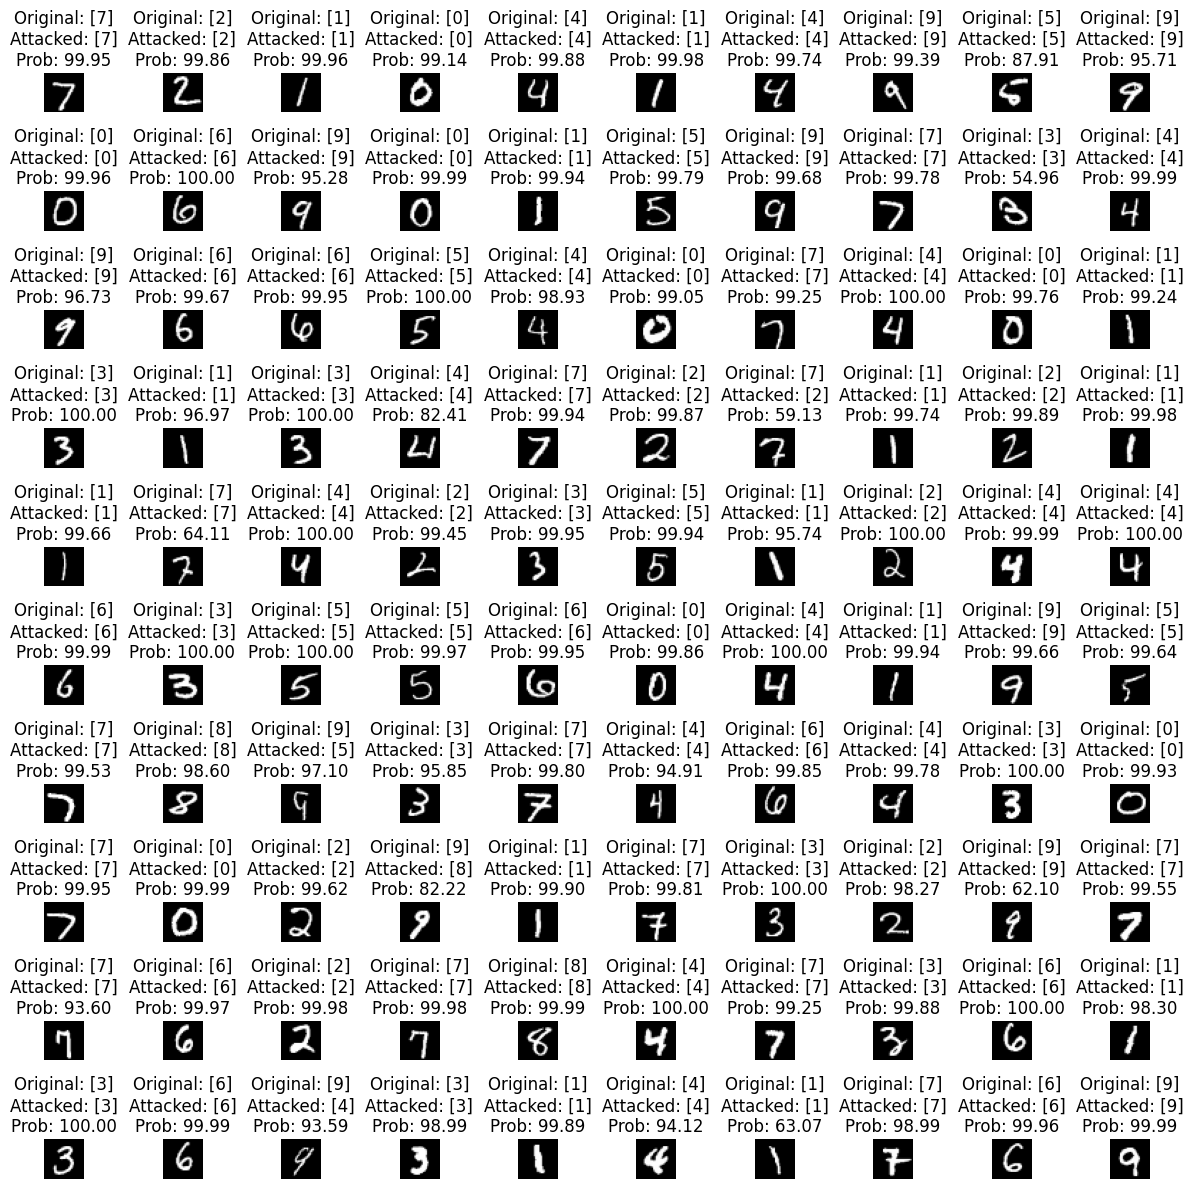

In [10]:
import numpy as np

def visualize_fgsm_attack(original_images, attacked_images, original_labels, attacked_labels, probs):
    num_images = len(original_images)
    num_rows = 10
    num_cols = 10
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i][j].imshow(original_images[index].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')
                axes[i][j].set_title(f'Original: {original_labels[index]}\nAttacked: {attacked_labels[index]}\nProb: {np.max(np.round(probs[index]*100, 2)):.2f}')
            else:
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()

visualize_fgsm_attack(original_images, attacked_images, original_labels, attacked_labels, probabilities_attacked)
